# Flight Data Comparison - OpenRocket vs Actual Flight

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Data Loading Functions

In [2]:
def read_pf2(fname):
    """Read .pf2 flight data file"""
    f = open(fname, 'r')
    lns = f.readlines()
    f.close()
    
    # get metadata stuff
    meta = {}
    start_idx = None
    
    for i, ln in enumerate(lns):
        ln = ln.strip()
        
        if ':' in ln and not ln.startswith('Data:'):
            pts = ln.split(':', 1)
            if len(pts) == 2:
                k = pts[0].strip()
                v = pts[1].strip()
                meta[k] = v
        
        # find where data starts
        if ln.startswith('Data:'):
            start_idx = i + 1
            break
    
    # read data lines
    data_lns = [ln.strip() for ln in lns[start_idx:] if ln.strip()]
    
    # parse it
    dat = []
    for ln in data_lns:
        vals = [x.strip() for x in ln.split(',')]
        dat.append(vals)
    
    # make dataframe
    df = pd.DataFrame(dat, columns=['t', 'alt', 'vel', 'temp', 'volt'])
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return meta, df

In [3]:
def read_openrocket_csv(csvfile):
    """Read OpenRocket simulation CSV file (fixes the column header issue)"""
    # Read the file to find the header line
    with open(csvfile, 'r') as f:
        lines = f.readlines()
    
    # Find the line with column names (starts with # and has the column descriptions)
    header_line = None
    data_start = 0
    for i, line in enumerate(lines):
        if line.startswith('# Time (s)'):
            # This is the header line
            header_line = line.strip('# \n')
            data_start = i + 1
            break
    
    if header_line is None:
        raise ValueError("Could not find header line in OpenRocket CSV")
    
    # Parse column names from header
    columns = [col.strip() for col in header_line.split(',')]
    
    # Read data starting from data_start, skipping comment lines
    data_lines = []
    for line in lines[data_start:]:
        line = line.strip()
        if line and not line.startswith('#'):
            data_lines.append(line)
    
    # Parse data
    data = []
    for line in data_lines:
        vals = [float(x.strip()) for x in line.split(',')]
        data.append(vals)
    
    df = pd.DataFrame(data, columns=columns)
    
    # Create simplified column names and convert to feet
    df['t'] = df['Time (s)']
    df['alt_ft'] = df['Altitude (m)'] * 3.28084
    df['vel_ft'] = df['Vertical velocity (m/s)'] * 3.28084
    df['acc'] = df['Vertical acceleration (m/s²)']
    
    return df[['t', 'alt_ft', 'vel_ft', 'acc']]

## 2. Load Files

**UPDATE THE FILE PATHS BELOW:**

In [12]:
# ===== UPDATE THESE PATHS =====
sim_file = '/Users/poorvivijay/x.csv'  #  OpenRocket simulation

# Choose ONE of these options:
flight_pf2 ='/Users/poorvivijay/Downloads/Altimeter 2/Launch 25.pf2'  # Option 1: .pf2 file
flight_csv = None  # '/Users/poorvivijay/your_flight.csv'  # Option 2: Already converted CSV
# ===============================

In [13]:
# Load OpenRocket simulation
print("Loading OpenRocket simulation...")
sim_df = read_openrocket_csv(sim_file)
print(f"✓ Loaded {len(sim_df)} simulation data points")
print(f"  Sim apogee: {sim_df['alt_ft'].max():.1f} ft")
print("\nFirst few rows:")
print(sim_df.head())

Loading OpenRocket simulation...
✓ Loaded 437 simulation data points
  Sim apogee: 824.9 ft

First few rows:
      t    alt_ft    vel_ft     acc
0  0.01  0.000459  0.091864   2.799
1  0.02  0.006562  0.895669  24.542
2  0.03  0.019685  2.063648  35.540
3  0.04  0.049213  3.464567  42.749
4  0.05  0.091864  5.019685  47.375


In [14]:
# Load actual flight data
if flight_pf2:
    print(f"Loading flight data from {flight_pf2}...")
    meta, flight_df = read_pf2(flight_pf2)
    print(f"Loaded {len(flight_df)} flight data points")
    print("\nFlight metadata:")
    for k, v in meta.items():
        print(f"  {k}: {v}")
    print(f"\nFlight apogee: {flight_df['alt'].max():.1f} ft")
elif flight_csv:
    print(f"Loading flight data from {flight_csv}...")
    flight_df = pd.read_csv(flight_csv, comment='#')
    meta = None
    print(f"Loaded {len(flight_df)} flight data points")
    print(f"Flight apogee: {flight_df['alt'].max():.1f} ft")
else:
    print("No flight data loaded yet")
    print("Update flight_pf2 or flight_csv above and re-run this cell")
    flight_df = None
    meta = None

Loading flight data from /Users/poorvivijay/Downloads/Altimeter 2/Launch 25.pf2...
✓ Loaded 976 flight data points

Flight metadata:
  Firmware: 1.0
  Software: 1.16
  Serial Number: 6990
  Apogee: 753' AGL
  Ground Elevation: -169' MSL
  NumSamps: 976
  Flight Number: 25
  Comments: 

Flight apogee: 761.0 ft


## 3. Simulation Only Plots

If you don't have flight data yet, run this to see your simulation:

In [ ]:
if flight_df is None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Altitude
    ax = axes[0, 0]
    ax.plot(sim_df['t'], sim_df['alt_ft'], 'b-', linewidth=2)
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Altitude (ft)', fontsize=11)
    ax.set_title('Simulated Altitude', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Velocity
    ax = axes[0, 1]
    ax.plot(sim_df['t'], sim_df['vel_ft'], 'b-', linewidth=2)
    ax.set_xlabel('Time (s)', fontsize=11)z
    ax.set_ylabel('Velocity (ft/s)', fontsize=11)
    ax.set_title('Simulated Velocity', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Acceleration
    ax = axes[1, 0]
    ax.plot(sim_df['t'], sim_df['acc'], 'b-', linewidth=2)
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Acceleration (m/s²)', fontsize=11)
    ax.set_title('Simulated Acceleration', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Stats
    ax = axes[1, 1]
    ax.axis('off')
    stats = f"""SIMULATION STATISTICS
═══════════════════════

Max Altitude:   {sim_df['alt_ft'].max():.1f} ft
                ({sim_df['alt_ft'].max()/3.28084:.1f} m)

Max Velocity:   {sim_df['vel_ft'].max():.1f} ft/s
                ({sim_df['vel_ft'].max()/3.28084:.1f} m/s)

Max Accel:      {sim_df['acc'].max():.1f} m/s²
                ({sim_df['acc'].max()/9.81:.1f} G)

Flight Time:    {sim_df['t'].max():.1f} s

Time to Apogee: {sim_df.loc[sim_df['alt_ft'].idxmax(), 't']:.2f} s
"""
    ax.text(0.1, 0.95, stats, transform=ax.transAxes,
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
else:
    print("Flight data is loaded - skip to the comparison section below!")

## 4. Flight Comparison (Run this when you have both files)

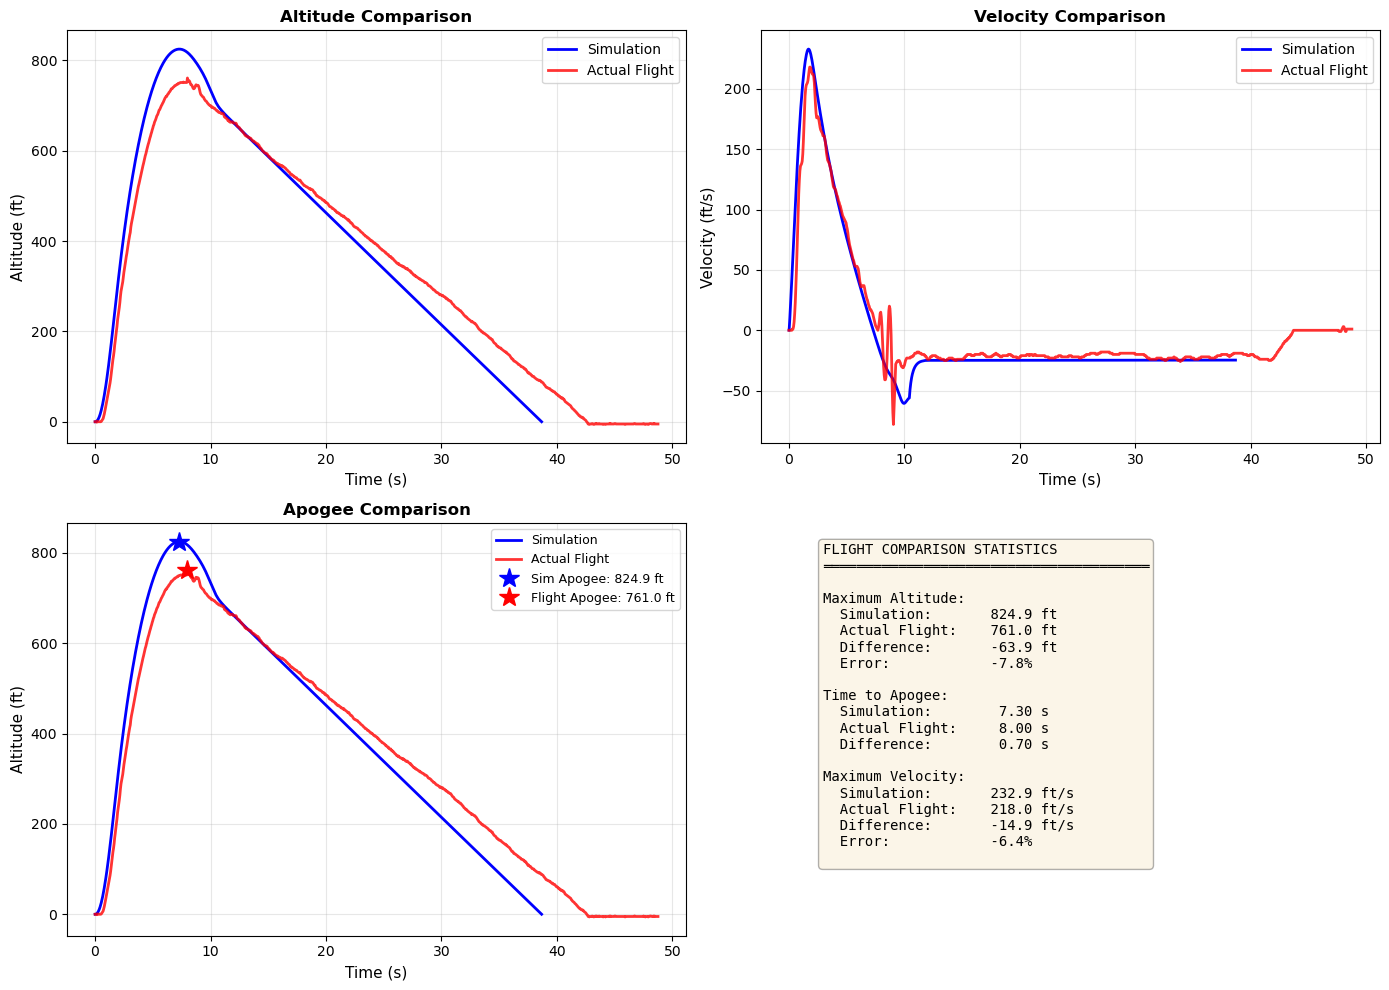

In [15]:
if flight_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Altitude comparison
    ax = axes[0, 0]
    ax.plot(sim_df['t'], sim_df['alt_ft'], 'b-', label='Simulation', linewidth=2)
    ax.plot(flight_df['t'], flight_df['alt'], 'r-', label='Actual Flight', linewidth=2, alpha=0.8)
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Altitude (ft)', fontsize=11)
    ax.set_title('Altitude Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Velocity comparison
    ax = axes[0, 1]
    ax.plot(sim_df['t'], sim_df['vel_ft'], 'b-', label='Simulation', linewidth=2)
    ax.plot(flight_df['t'], flight_df['vel'], 'r-', label='Actual Flight', linewidth=2, alpha=0.8)
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Velocity (ft/s)', fontsize=11)
    ax.set_title('Velocity Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Altitude overlay with apogee markers
    ax = axes[1, 0]
    sim_apogee_idx = sim_df['alt_ft'].idxmax()
    flight_apogee_idx = flight_df['alt'].idxmax()
    
    sim_apogee_time = sim_df.loc[sim_apogee_idx, 't']
    flight_apogee_time = flight_df.loc[flight_apogee_idx, 't']
    
    # Plot full altitude
    ax.plot(sim_df['t'], sim_df['alt_ft'], 'b-', label='Simulation', linewidth=2)
    ax.plot(flight_df['t'], flight_df['alt'], 'r-', label='Actual Flight', linewidth=2, alpha=0.8)
    
    # Mark apogees
    ax.plot(sim_apogee_time, sim_df.loc[sim_apogee_idx, 'alt_ft'], 'b*', 
            markersize=15, label=f'Sim Apogee: {sim_df.loc[sim_apogee_idx, "alt_ft"]:.1f} ft')
    ax.plot(flight_apogee_time, flight_df.loc[flight_apogee_idx, 'alt'], 'r*', 
            markersize=15, label=f'Flight Apogee: {flight_df.loc[flight_apogee_idx, "alt"]:.1f} ft')
    
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Altitude (ft)', fontsize=11)
    ax.set_title('Apogee Comparison', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Statistics table
    ax = axes[1, 1]
    ax.axis('off')
    
    # Calculate stats
    sim_max_alt = sim_df['alt_ft'].max()
    flight_max_alt = flight_df['alt'].max()
    sim_max_vel = sim_df['vel_ft'].max()
    flight_max_vel = flight_df['vel'].max()
    sim_time_to_apogee = sim_df.loc[sim_apogee_idx, 't']
    flight_time_to_apogee = flight_df.loc[flight_apogee_idx, 't']
    
    # Create stats text
    stats_text = f"""FLIGHT COMPARISON STATISTICS
═══════════════════════════════════════

Maximum Altitude:
  Simulation:    {sim_max_alt:>8.1f} ft
  Actual Flight: {flight_max_alt:>8.1f} ft
  Difference:    {flight_max_alt - sim_max_alt:>8.1f} ft
  Error:         {((flight_max_alt - sim_max_alt)/sim_max_alt * 100):>+7.1f}%

Time to Apogee:
  Simulation:    {sim_time_to_apogee:>8.2f} s
  Actual Flight: {flight_time_to_apogee:>8.2f} s
  Difference:    {flight_time_to_apogee - sim_time_to_apogee:>8.2f} s

Maximum Velocity:
  Simulation:    {sim_max_vel:>8.1f} ft/s
  Actual Flight: {flight_max_vel:>8.1f} ft/s
  Difference:    {flight_max_vel - sim_max_vel:>8.1f} ft/s
  Error:         {((flight_max_vel - sim_max_vel)/sim_max_vel * 100):>+7.1f}%
"""
    
    ax.text(0.1, 0.95, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Load flight data first (see section 2 above)")

## 5. Detailed Analysis (Optional)

In [ ]:
# Print detailed statistics
if flight_df is not None:
    print("DETAILED COMPARISON\n" + "="*50)
    
    print("\nALTITUDE")
    print(f"  Simulated: {sim_df['alt_ft'].max():.1f} ft ({sim_df['alt_ft'].max()/3.28084:.1f} m)")
    print(f"  Actual:    {flight_df['alt'].max():.1f} ft")
    print(f"  Error:     {((flight_df['alt'].max() - sim_df['alt_ft'].max())/sim_df['alt_ft'].max() * 100):+.2f}%")
    
    print("\nVELOCITY")
    print(f"  Simulated: {sim_df['vel_ft'].max():.1f} ft/s ({sim_df['vel_ft'].max()/3.28084:.1f} m/s)")
    print(f"  Actual:    {flight_df['vel'].max():.1f} ft/s")
    print(f"  Error:     {((flight_df['vel'].max() - sim_df['vel_ft'].max())/sim_df['vel_ft'].max() * 100):+.2f}%")
    
    print("\nTIMING")
    sim_apogee_time = sim_df.loc[sim_df['alt_ft'].idxmax(), 't']
    flight_apogee_time = flight_df.loc[flight_df['alt'].idxmax(), 't']
    print(f"  Sim time to apogee:    {sim_apogee_time:.2f} s")
    print(f"  Flight time to apogee: {flight_apogee_time:.2f} s")
    print(f"  Difference:            {flight_apogee_time - sim_apogee_time:+.2f} s")
    
    if meta:
        print("\nFLIGHT METADATA")
        for k, v in meta.items():
            print(f"  {k}: {v}")
else:
    print("Load flight data to see detailed comparison")

## 6. Export Data (Optional)

In [ ]:
# Save comparison data to CSV
if flight_df is not None:
    # Create a combined dataframe (if they have the same length)
    comparison = pd.DataFrame({
        'time_sim': sim_df['t'],
        'alt_sim_ft': sim_df['alt_ft'],
        'vel_sim_ft': sim_df['vel_ft'],
    })
    
    comparison.to_csv('flight_comparison_data.csv', index=False)
    print("✓ Saved comparison data to flight_comparison_data.csv")
    
    # Also save the flight data separately
    flight_df.to_csv('actual_flight_data.csv', index=False)
    print("✓ Saved actual flight data to actual_flight_data.csv")